### **Tutorial:MTG**

This experiment includes datasets from three developmental stages of the chicken heart: D7, D10, and D14. Using the D14 dataset as a representative example, we demonstrate the workflow of SpatialModal, including spatial clustering and downstream single-cell type analysis, to explore the spatial organization and cellular heterogeneity during organogenesis.

#### **Loading package**

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

In [2]:
import torch
from Spatialmodal.spatialmodal import SpatialModal
from Spatialmodal.reconstruction import RF
from Spatialmodal.data_process import load_ST_file
from Spatialmodal.utils import mclust_R
from sklearn.decomposition import PCA
import scanpy as sc
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import squidpy as sq
from tqdm import tqdm
import numpy as np
import scipy as sp
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/home/zhaodongmin/.conda/envs/task_spa/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhaodongmin/.conda/envs/task_spa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/zhaodongmin/.conda/envs/task_spa/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

#### **Loading ST data**

In [ ]:
stage = 'D14'
fold = f"../Data/chicken_heart/{stage}"
adata = load_ST_file(fold)
region = pd.read_csv("f../Data/chicken_heart/spatialRNAseq_metadata.csv", index_col=0)
region = region[region.index.str.startswith(f"{stage}-")]
region.index = region.index.str.split('_').str[-1]
adata.obs['region'] = region['region']
n_clusters = adata.obs['region'].nunique()

#### **Training the modal**

In [5]:
model = SpatialModal(adata, device=device, epochs=1000, fold=fold, image_use=True, if_img=True)
adata = model.train()

Tiling image: 100%|██████████ [ time left: 00:00 ]
Extracting features: 100%|██████████ [ time left: 00:00 ]
Training SpatialModal: 100%|██████████ [ time left: 00:00 ]


#### **Spatial clustering**

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


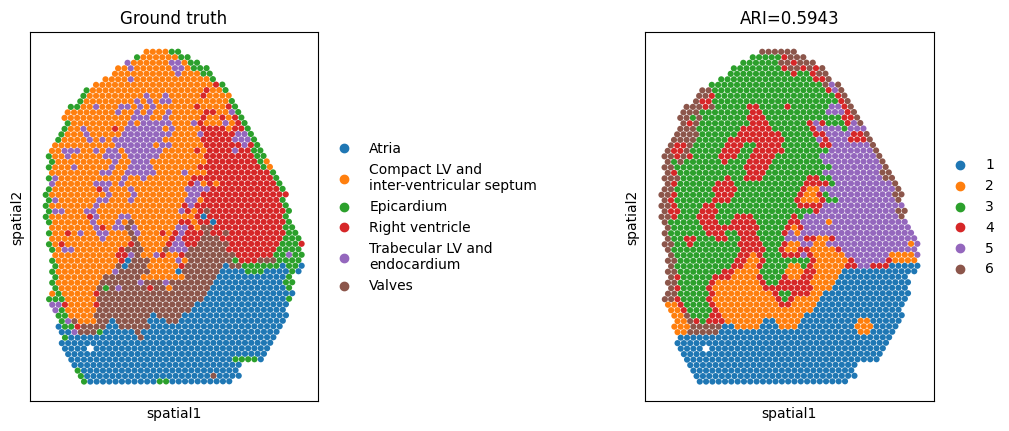

In [ ]:
pca = PCA(n_components=20, random_state=42)
embedding = pca.fit_transform(adata.obsm['emb'].copy())
adata.obsm['emb_pca'] = embedding
mclust_R(adata, n_clusters, use_rep='emb_pca', key_added='domain')

ARI = metrics.adjusted_rand_score(adata.obs['region'], adata.obs['domain'])
sc.pl.spatial(adata,
              img_key=None,
              color=["region", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True,
              size=1.5)

#### **Single-cell type analysis & domain composition**

In this section, we map predicted cell types to spatial locations and visualize their distribution. We then determine an optimal spatial radius to analyze local neighborhoods and generate a normalized heatmap to reveal the specific cellular composition and enrichment within each identified spatial domain.

In [ ]:
celltype = pd.read_csv(f"../Data/chicken_heart/spatialRNAseq_metadata.csv", index_col=0)
celltype = celltype[celltype.index.str.startswith(f"{stage}-")]
celltype.index = celltype.index.str.split('_').str[-1]
adata.obs['celltype'] = celltype['celltype_prediction']

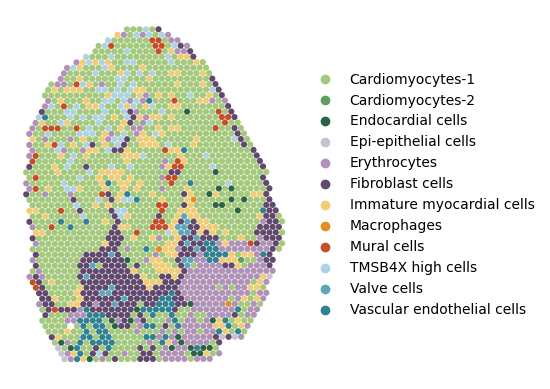

In [ ]:
region_colors_celltype = {
    'Cardiomyocytes-1': "#A4C97C",  
    'Cardiomyocytes-2': "#5F9C61",  
    'Endocardial cells': "#2C6344",  
    'Epi-epithelial cells': "#CAC1D4",  
    'Erythrocytes': "#B092B6",  
    'Fibroblast cells': "#61496D",  
    'Immature myocardial cells': "#F1CC74",  
    'Macrophages': "#E38D26",
    'Mural cells': "#C74D26",  
    'TMSB4X high cells': "#AED2E2", 
    'Valve cells': "#5EA7B8",
    'Vascular endothelial cells': "#308192",
    'MT-enriched cardiomyocytes': "#FEC0C1"
}

sc.pl.spatial(
    adata,
    color='celltype',
    show=False,
    img_key=None,
    palette=region_colors_celltype,
    size=1.5,
    title="",        
    frameon=False,    
    colorbar_loc=None, 
)
plt.show()

In [ ]:
radii = [280, 290, 300, 310, 320, 400]
moran_scores = []
for r in radii:
    sq.gr.spatial_neighbors(adata, radius=r, coord_type='generic')
    sq.gr.spatial_autocorr(adata, mode="moran")
    moran_scores.append(adata.uns["moranI"].mean())

optimal_radius = radii[np.argmax(np.diff(moran_scores) < 0.1) + 1]

point_tree = sp.spatial.cKDTree(adata.obsm['spatial'])
neigh_inds_list = point_tree.query_ball_point(adata.obsm['spatial'], optimal_radius)
neigh_celltype_df = pd.DataFrame(adata.obs['celltype'][neigh_inds_list[0]].value_counts())
neigh_celltype_list = []
for i in tqdm(range(len(neigh_inds_list))):
    neigh_inds = neigh_inds_list[i]
    celltype_counts = pd.DataFrame(adata.obs['celltype'][neigh_inds].value_counts())
    neigh_celltype_list.append(celltype_counts)
neigh_celltype_df = pd.concat(neigh_celltype_list, axis=1)
    
neigh_celltype_df.columns = adata.obs.index
neigh_celltype_df = neigh_celltype_df.T
neigh_celltype_df = neigh_celltype_df.fillna(0.0).astype('int')
neigh_celltype_df.columns = neigh_celltype_df.columns.astype(str)
neigh_celltype_df.head()

100%|██████████| 1967/1967 [00:00<00:00, 2368.08it/s]


celltype,Immature myocardial cells,Erythrocytes,Cardiomyocytes-1,Cardiomyocytes-2,Fibroblast cells,Endocardial cells,Epi-epithelial cells,Macrophages,Mural cells,TMSB4X high cells,Valve cells,Vascular endothelial cells
AAACAAGTATCTCCCA-1,2,2,1,1,1,0,0,0,0,0,0,0
AAACATTTCCCGGATT-1,4,0,0,0,0,0,0,0,0,0,0,3
AAACCCGAACGAAATC-1,0,0,2,0,4,0,0,0,0,0,0,0
AAACCGTTCGTCCAGG-1,1,1,5,0,0,0,0,0,0,0,0,0
AAACCTAAGCAGCCGG-1,0,5,0,0,0,2,0,0,0,0,0,0


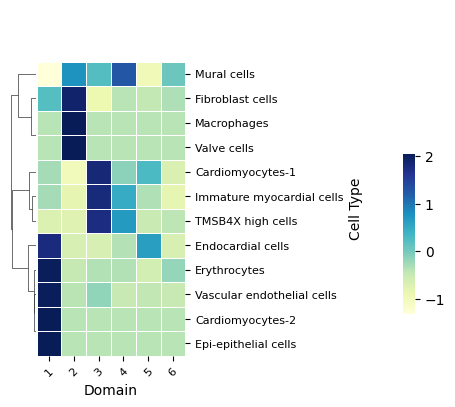

In [10]:
df = adata.obs.groupby(['celltype','domain']).size().unstack(fill_value=0).to_numpy()
plot_df = pd.DataFrame(df, 
                       index=adata.obs['celltype'].cat.categories, 
                       columns=adata.obs['domain'].cat.categories)
plot_df_norm_row = plot_df.apply(lambda x: (x-x.mean())/x.std(), axis = 1)
g = sns.clustermap(plot_df_norm_row, 
                   col_cluster=False, 
                   cmap='YlGnBu', 
                   linewidths=0.5, 
                   figsize=(4, 4), 
                   dendrogram_ratio=0.15, 
                   cbar_pos=(1.02, 0.2, 0.03, 0.4)) 

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), rotation=45, fontsize=8)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8)
g.ax_heatmap.set_xlabel("Domain", fontsize=10)
g.ax_heatmap.set_ylabel("Cell Type", fontsize=10)

plt.show()
